# Loess regres

## Úkol 1

### Cíl

Porovnat výkonnost LOESS regrese a polynomiální regrese při modelování vztahů mezi atributy v datové sadě **manufacturing.csv**, přičemž **Hodnocení kvality** je cílová proměnná.

### Postup

- Rozdělení dat na trénovací a testovací množinu (70/30).
- Aplikace LOESS regrese na všechny atributy vzhledem k **Hodnocení kvality**.
- Hodnocení efektivity modelů pomocí RMSE a R-squared.
- Vizuální porovnání predikcí obout metod.

In [1]:
import gdown
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from pyloess import loess
import warnings
warnings.filterwarnings('ignore')

# Configure plotting
plt.style.use('default')
sns.set_style("whitegrid")

# Constants
DATASET_DIR = Path("datasets")
DATASET_DIR.mkdir(exist_ok=True)
DATASET = DATASET_DIR / "manufacturing.csv"
DATASET_URL = "https://drive.google.com/drive/folders/1gK5IsrYbTguM5rmjFpmrYXOOF_33K5sh"
TEST_SIZE = 0.3
RANDOM_STATE = 42
MAX_POLY_DEGREE = 10
LOESS_SPAN = 0.7


In [2]:
# Download data if needed
if not DATASET.exists():
    gdown.download_folder(url=DATASET_URL, output=str(DATASET_DIR), use_cookies=False)

# Load data
df = pd.read_csv(DATASET)
print("Dataset Info:")
df.info()
print("\nDataset Statistics:")
print(df.describe())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3957 entries, 0 to 3956
Data columns (total 6 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Temperature (°C)                3957 non-null   float64
 1   Pressure (kPa)                  3957 non-null   float64
 2   Temperature x Pressure          3957 non-null   float64
 3   Material Fusion Metric          3957 non-null   float64
 4   Material Transformation Metric  3957 non-null   float64
 5   Quality Rating                  3957 non-null   float64
dtypes: float64(6)
memory usage: 185.6 KB

Dataset Statistics:
       Temperature (°C)  Pressure (kPa)  Temperature x Pressure  \
count       3957.000000     3957.000000             3957.000000   
mean         200.034704       14.815558             2955.321308   
std           58.135717        5.772040             1458.224940   
min          100.014490        5.003008              513.7068

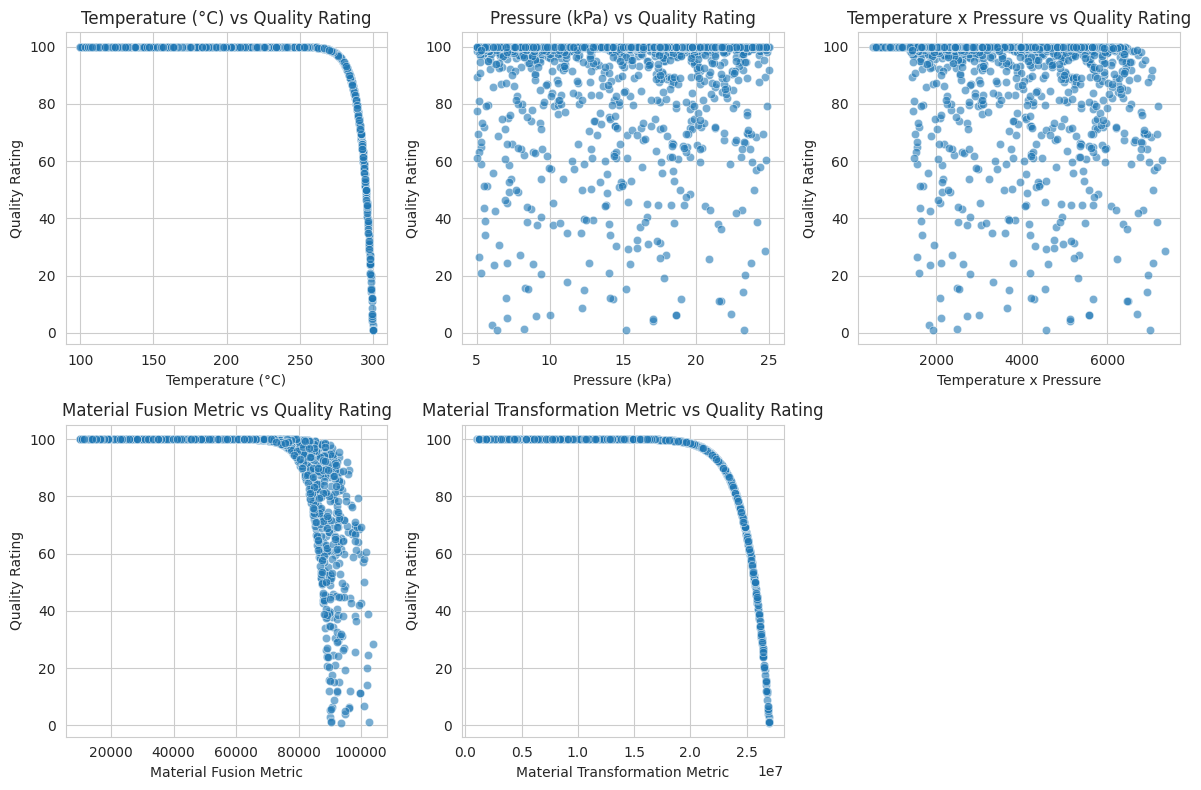

In [3]:
# Visualize relationships
y_col = "Quality Rating"
input_columns = [col for col in df.columns if col != y_col]

n_cols = min(3, len(input_columns))
n_rows = (len(input_columns) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
if n_rows == 1:
    axes = [axes] if n_cols == 1 else axes
else:
    axes = axes.flatten()

for i, column in enumerate(input_columns):
    ax = axes[i] if len(input_columns) > 1 else axes
    sns.scatterplot(x=column, y=y_col, data=df, ax=ax, alpha=0.6)
    ax.set_title(f'{column} vs {y_col}')
    ax.grid(True)

# Hide unused subplots
if len(input_columns) > 1:
    for j in range(len(input_columns), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [4]:
def evaluate_models(df, x_col, y_col):
    """Compare LOESS and polynomial regression on single feature"""
    X = df[[x_col]].values
    y = df[y_col].values
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
    )
    
    # --- LOESS Regression ---
    y_pred_loess = loess(X_train.flatten(), y_train, eval_x=X_test.flatten(), 
                        span=LOESS_SPAN, degree=2)
    
    loess_metrics = {
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_loess)),
        "R2": r2_score(y_test, y_pred_loess)
    }
    
    # --- Polynomial Regression ---
    poly_results = []
    
    for degree in range(1, MAX_POLY_DEGREE + 1):
        poly = PolynomialFeatures(degree=degree, include_bias=False)
        X_poly_train = poly.fit_transform(X_train)
        X_poly_test = poly.transform(X_test)
        
        model = LinearRegression()
        model.fit(X_poly_train, y_train)
        y_pred = model.predict(X_poly_test)
        
        metrics = {
            "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
            "R2": r2_score(y_test, y_pred)
        }
        
        poly_results.append({
            "degree": degree,
            "model": model,
            "transformer": poly,
            "metrics": metrics,
            "y_pred": y_pred
        })
    
    # Find best polynomial by RMSE
    best_poly = min(poly_results, key=lambda r: r["metrics"]["RMSE"])
    
    return {
        "loess": {"metrics": loess_metrics, "y_pred": y_pred_loess},
        "polynomial": poly_results,
        "best_poly": best_poly,
        "test_data": (X_test, y_test, X_train, y_train)
    }


def plot_comparison(df, x_col, y_col, results):
    """Visualize LOESS vs best polynomial regression"""
    X_test, y_test, X_train, y_train = results["test_data"]
    loess_pred = results["loess"]["y_pred"]
    best_poly_pred = results["best_poly"]["y_pred"]
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Original data with fit lines
    X_sorted = np.sort(X_train.flatten())
    y_loess_smooth = loess(X_train.flatten(), y_train, eval_x=X_sorted, 
                          span=LOESS_SPAN, degree=2)
    
    # Polynomial smooth curve
    poly = results["best_poly"]["transformer"]
    model = results["best_poly"]["model"]
    X_poly_smooth = poly.transform(X_sorted.reshape(-1, 1))
    y_poly_smooth = model.predict(X_poly_smooth)
    
    axes[0,0].scatter(X_train, y_train, alpha=0.5, label='Training Data', color='lightblue')
    axes[0,0].plot(X_sorted, y_loess_smooth, color='red', linewidth=2, label='LOESS Fit')
    axes[0,0].plot(X_sorted, y_poly_smooth, color='green', linewidth=2, 
                   label=f'Polynomial Fit (deg {results["best_poly"]["degree"]})')
    axes[0,0].set_xlabel(x_col)
    axes[0,0].set_ylabel(y_col)
    axes[0,0].set_title(f'Fitted Curves: {x_col}')
    axes[0,0].legend()
    axes[0,0].grid(True)
    
    # Scatter plot with predictions
    axes[0,1].scatter(X_test, y_test, alpha=0.6, label='Actual', color='blue')
    axes[0,1].scatter(X_test, loess_pred, alpha=0.6, label='LOESS', color='red')
    axes[0,1].scatter(X_test, best_poly_pred, alpha=0.6, 
                     label=f'Poly (deg {results["best_poly"]["degree"]})', color='green')
    axes[0,1].set_xlabel(x_col)
    axes[0,1].set_ylabel(y_col)
    axes[0,1].set_title('Test Predictions')
    axes[0,1].legend()
    axes[0,1].grid(True)
    
    # Residuals plot
    loess_residuals = y_test - loess_pred
    poly_residuals = y_test - best_poly_pred
    
    axes[1,0].scatter(loess_pred, loess_residuals, alpha=0.6, label='LOESS', color='red')
    axes[1,0].scatter(best_poly_pred, poly_residuals, alpha=0.6, label='Polynomial', color='green')
    axes[1,0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[1,0].set_xlabel('Predicted Values')
    axes[1,0].set_ylabel('Residuals')
    axes[1,0].set_title('Residuals Plot')
    axes[1,0].legend()
    axes[1,0].grid(True)
    
    # Model comparison metrics
    loess_rmse = results["loess"]["metrics"]["RMSE"]
    loess_r2 = results["loess"]["metrics"]["R2"]
    poly_rmse = results["best_poly"]["metrics"]["RMSE"]
    poly_r2 = results["best_poly"]["metrics"]["R2"]
    
    metrics_text = f"""LOESS (span={LOESS_SPAN}):
    RMSE: {loess_rmse:.3f}
    R²: {loess_r2:.3f}

    Polynomial (deg {results["best_poly"]["degree"]}):
    RMSE: {poly_rmse:.3f}
    R²: {poly_r2:.3f}

    Winner: {'LOESS' if loess_rmse < poly_rmse else 'Polynomial'}
    Improvement: {abs(loess_rmse - poly_rmse)/max(loess_rmse, poly_rmse)*100:.1f}%"""
    
    axes[1,1].text(0.1, 0.5, metrics_text, transform=axes[1,1].transAxes, 
                  fontsize=11, verticalalignment='center',
                  bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
    axes[1,1].set_xlim(0, 1)
    axes[1,1].set_ylim(0, 1)
    axes[1,1].axis('off')
    axes[1,1].set_title('Model Comparison')
    
    plt.tight_layout()
    plt.show()


=== LOESS vs Polynomial Regression Comparison ===
LOESS Configuration: span=0.7, degree=2
Polynomial degrees tested: 1-10


ANALYZING: TEMPERATURE (°C)

LOESS Regression:
  RMSE: 7.131
  R²: 0.746

Polynomial Regression Results:
  Degree  1 -> RMSE: 12.559, R²: 0.213
  Degree  2 -> RMSE: 10.381, R²: 0.462
  Degree  3 -> RMSE: 8.018, R²: 0.679
  Degree  4 -> RMSE: 5.845, R²: 0.829
  Degree  5 -> RMSE: 5.147, R²: 0.868
  Degree  6 -> RMSE: 4.493, R²: 0.899
  Degree  7 -> RMSE: 3.887, R²: 0.925
  Degree  8 -> RMSE: 3.331, R²: 0.945
  Degree  9 -> RMSE: 2.824, R²: 0.960
  Degree 10 -> RMSE: 2.369, R²: 0.972

>>> Best Polynomial: Degree 10
    RMSE: 2.369, R²: 0.972

🏆 WINNER: Polynomial (deg 10)
📊 RMSE Improvement: 66.8%


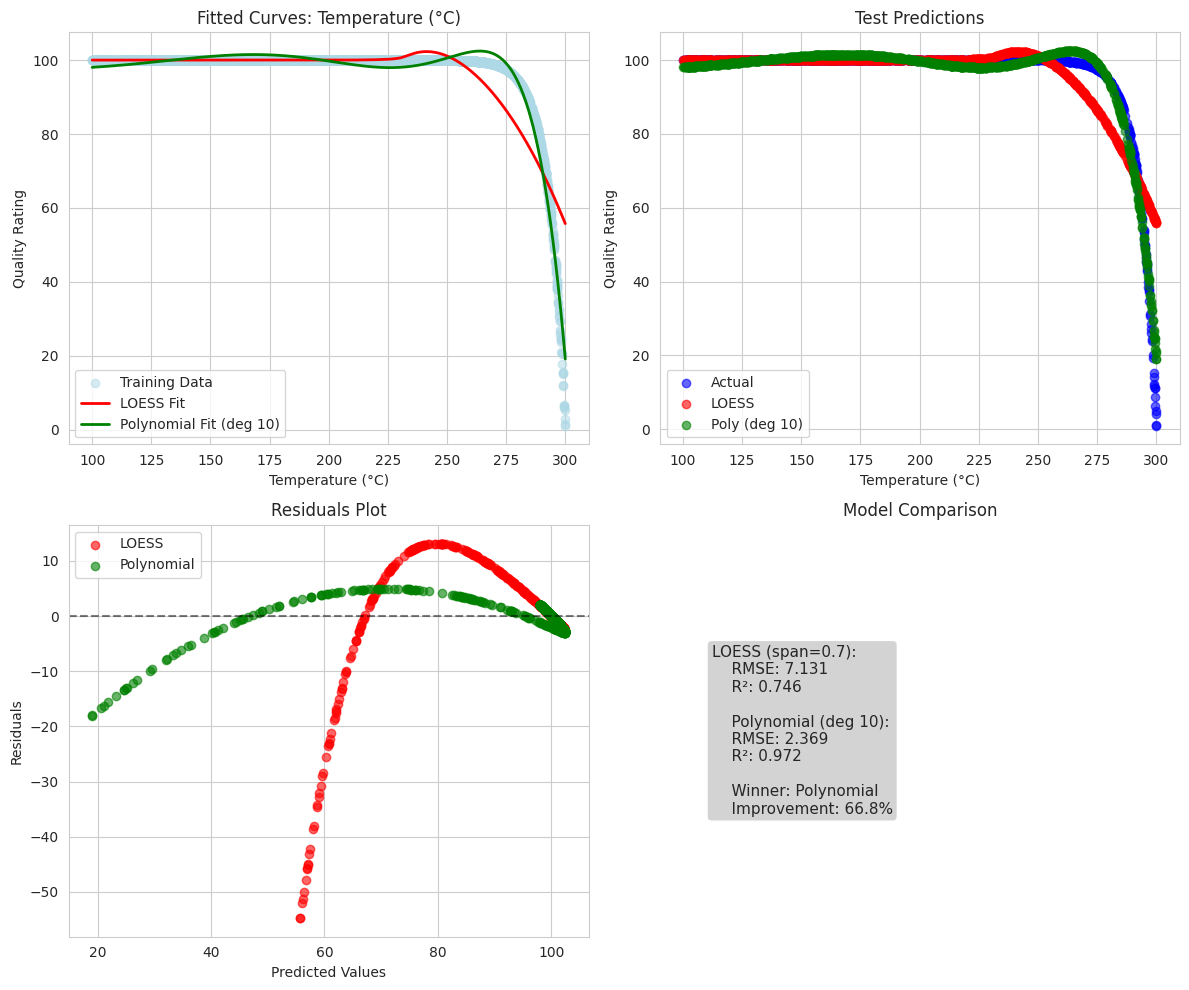


ANALYZING: PRESSURE (KPA)

LOESS Regression:
  RMSE: 14.172
  R²: -0.003

Polynomial Regression Results:
  Degree  1 -> RMSE: 14.178, R²: -0.003
  Degree  2 -> RMSE: 14.177, R²: -0.003
  Degree  3 -> RMSE: 14.173, R²: -0.003
  Degree  4 -> RMSE: 14.173, R²: -0.003
  Degree  5 -> RMSE: 14.172, R²: -0.003
  Degree  6 -> RMSE: 14.177, R²: -0.003
  Degree  7 -> RMSE: 14.176, R²: -0.003
  Degree  8 -> RMSE: 14.179, R²: -0.004
  Degree  9 -> RMSE: 14.179, R²: -0.004
  Degree 10 -> RMSE: 14.180, R²: -0.004

>>> Best Polynomial: Degree 5
    RMSE: 14.172, R²: -0.003

🏆 WINNER: LOESS
📊 RMSE Improvement: 0.0%


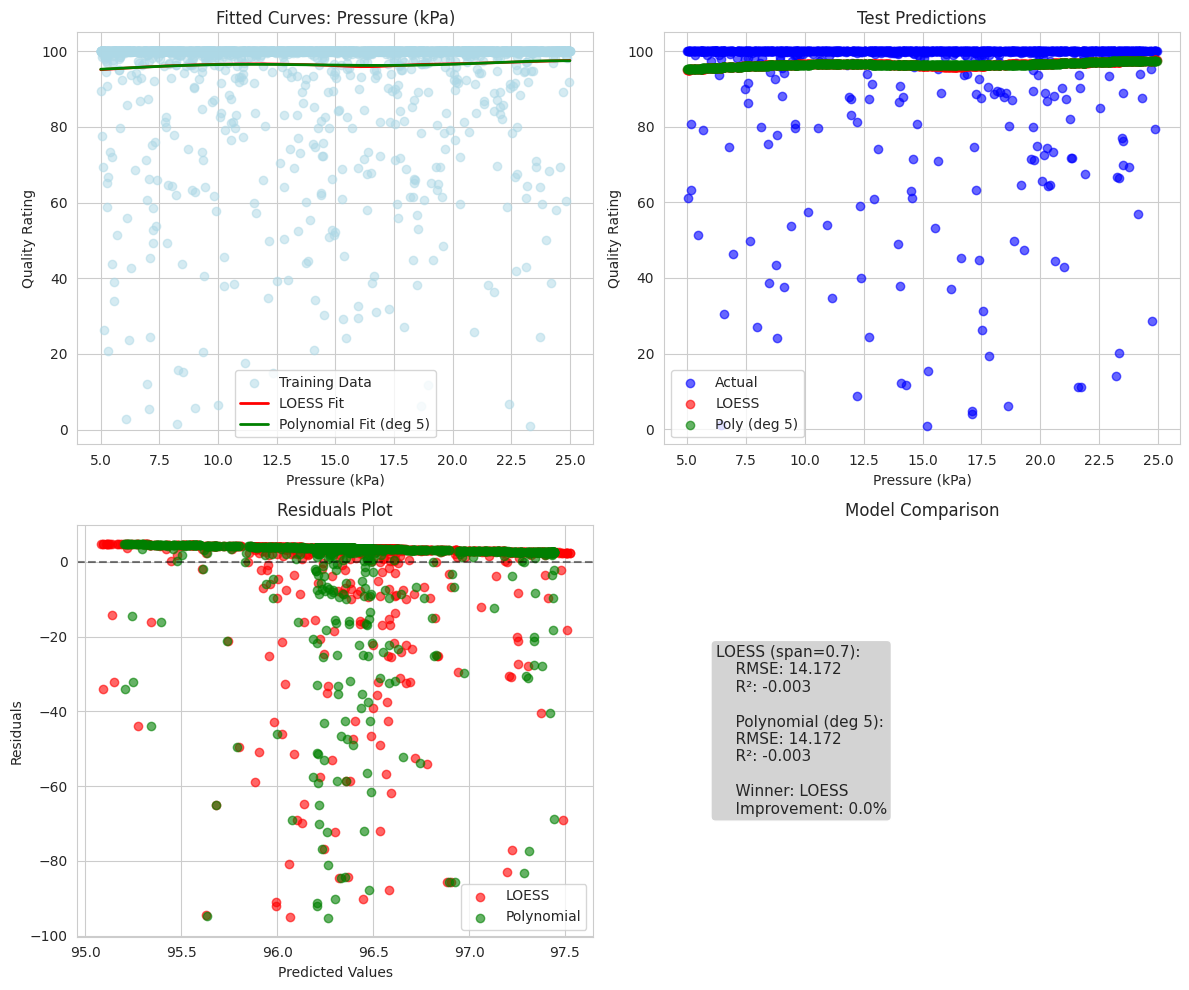


ANALYZING: TEMPERATURE X PRESSURE

LOESS Regression:
  RMSE: 13.274
  R²: 0.120

Polynomial Regression Results:
  Degree  1 -> RMSE: 13.557, R²: 0.083
  Degree  2 -> RMSE: 13.379, R²: 0.106
  Degree  3 -> RMSE: 13.287, R²: 0.119
  Degree  4 -> RMSE: 13.269, R²: 0.121
  Degree  5 -> RMSE: 13.258, R²: 0.123
  Degree  6 -> RMSE: 13.250, R²: 0.124
  Degree  7 -> RMSE: 13.244, R²: 0.124
  Degree  8 -> RMSE: 13.243, R²: 0.125
  Degree  9 -> RMSE: 13.246, R²: 0.124
  Degree 10 -> RMSE: 13.255, R²: 0.123

>>> Best Polynomial: Degree 8
    RMSE: 13.243, R²: 0.125

🏆 WINNER: Polynomial (deg 8)
📊 RMSE Improvement: 0.2%


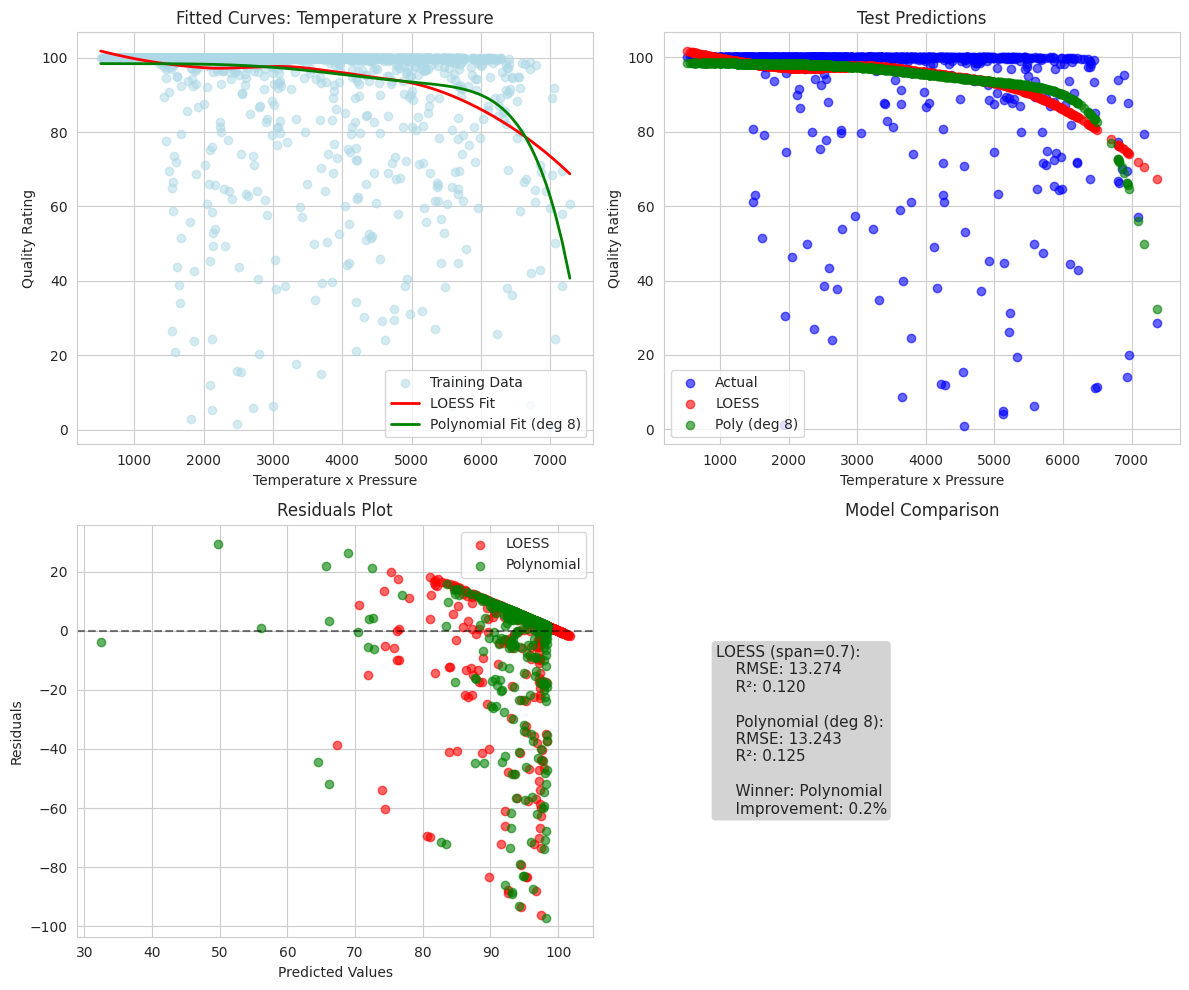


ANALYZING: MATERIAL FUSION METRIC

LOESS Regression:
  RMSE: 8.252
  R²: 0.660

Polynomial Regression Results:
  Degree  1 -> RMSE: 12.143, R²: 0.264
  Degree  2 -> RMSE: 9.783, R²: 0.522
  Degree  3 -> RMSE: 8.396, R²: 0.648
  Degree  4 -> RMSE: 8.213, R²: 0.663
  Degree  5 -> RMSE: 8.222, R²: 0.663
  Degree  6 -> RMSE: 8.247, R²: 0.661
  Degree  7 -> RMSE: 8.224, R²: 0.662
  Degree  8 -> RMSE: 8.166, R²: 0.667
  Degree  9 -> RMSE: 8.106, R²: 0.672
  Degree 10 -> RMSE: 8.066, R²: 0.675

>>> Best Polynomial: Degree 10
    RMSE: 8.066, R²: 0.675

🏆 WINNER: Polynomial (deg 10)
📊 RMSE Improvement: 2.3%


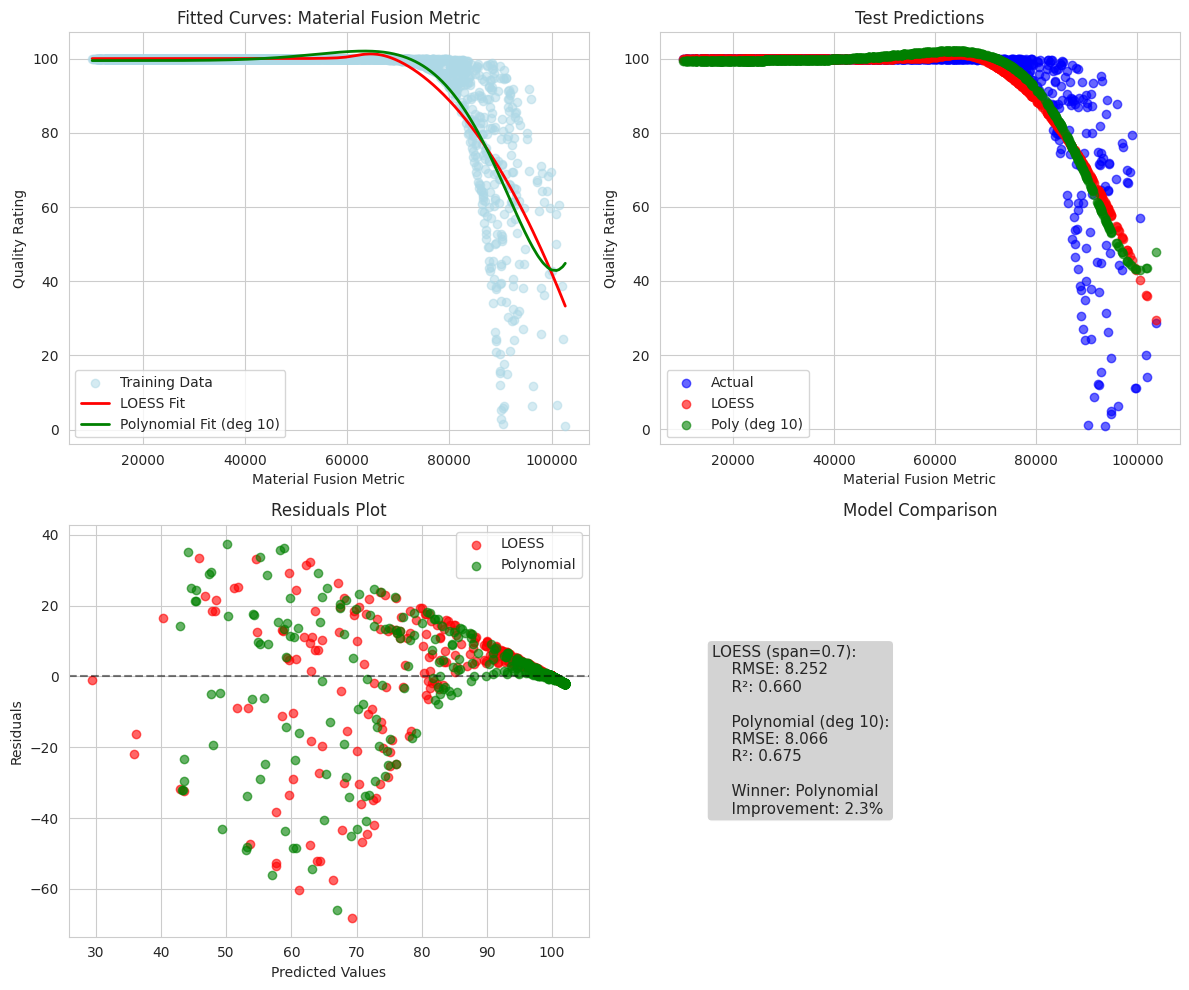


ANALYZING: MATERIAL TRANSFORMATION METRIC

LOESS Regression:
  RMSE: 5.259
  R²: 0.862

Polynomial Regression Results:
  Degree  1 -> RMSE: 11.561, R²: 0.333
  Degree  2 -> RMSE: 8.178, R²: 0.666
  Degree  3 -> RMSE: 6.265, R²: 0.804
  Degree  4 -> RMSE: 4.726, R²: 0.889
  Degree  5 -> RMSE: 3.512, R²: 0.938
  Degree  6 -> RMSE: 2.556, R²: 0.967
  Degree  7 -> RMSE: 1.809, R²: 0.984
  Degree  8 -> RMSE: 1.234, R²: 0.992
  Degree  9 -> RMSE: 0.802, R²: 0.997
  Degree 10 -> RMSE: 0.487, R²: 0.999

>>> Best Polynomial: Degree 10
    RMSE: 0.487, R²: 0.999

🏆 WINNER: Polynomial (deg 10)
📊 RMSE Improvement: 90.7%


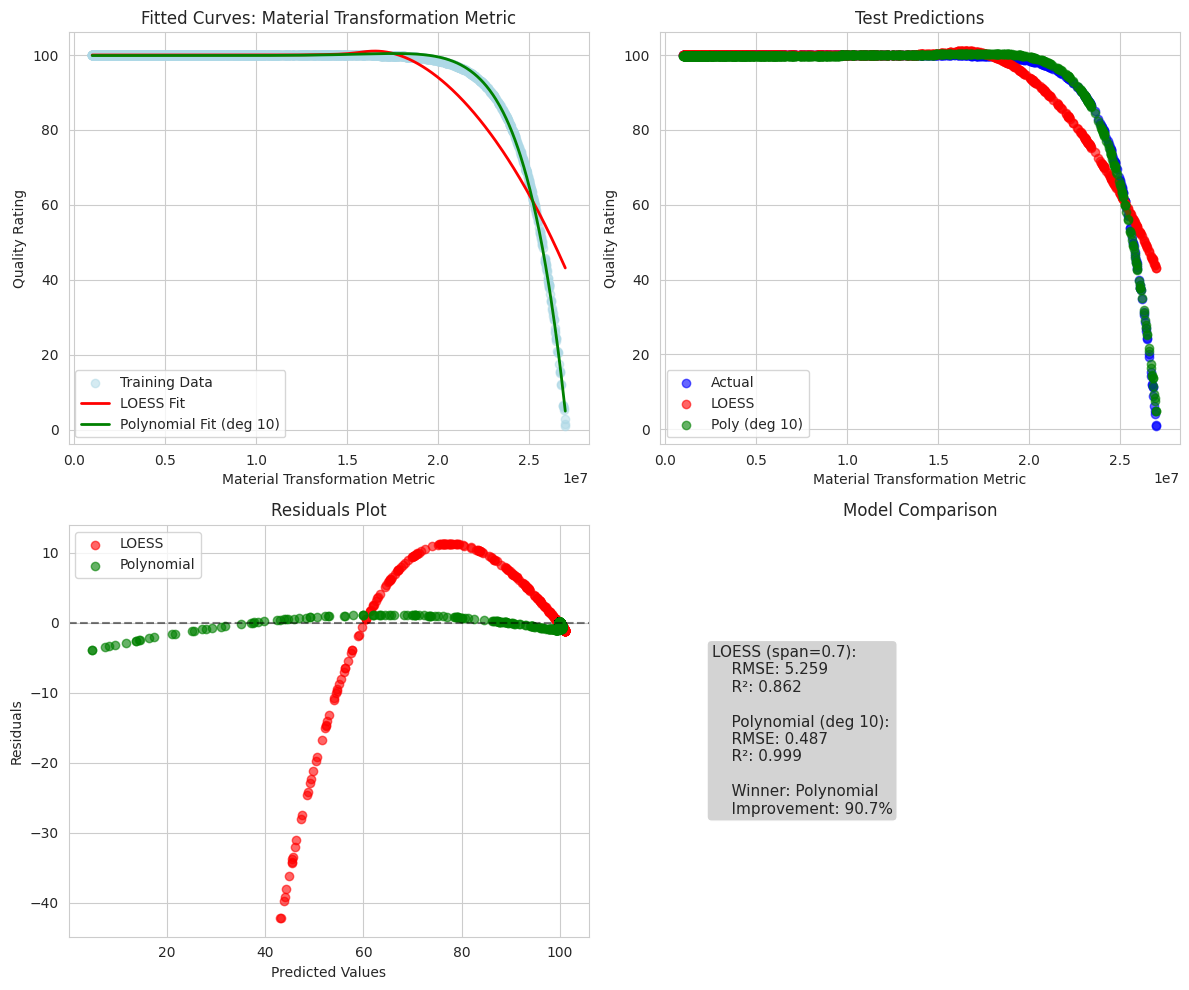

In [5]:
# Run analysis for each input variable
print("=== LOESS vs Polynomial Regression Comparison ===")
print(f"LOESS Configuration: span={LOESS_SPAN}, degree=2")
print(f"Polynomial degrees tested: 1-{MAX_POLY_DEGREE}\n")

summary_results = []

for x_col in input_columns:
    print(f"\n{'='*50}")
    print(f"ANALYZING: {x_col.upper()}")
    print(f"{'='*50}")
    
    # Evaluate models
    results = evaluate_models(df, x_col, y_col)
    
    # Print results
    loess_metrics = results["loess"]["metrics"]
    print(f"\nLOESS Regression:")
    print(f"  RMSE: {loess_metrics['RMSE']:.3f}")
    print(f"  R²: {loess_metrics['R2']:.3f}")
    
    print(f"\nPolynomial Regression Results:")
    for result in results["polynomial"]:
        deg = result["degree"]
        m = result["metrics"]
        print(f"  Degree {deg:2d} -> RMSE: {m['RMSE']:.3f}, R²: {m['R2']:.3f}")
    
    best_deg = results["best_poly"]["degree"]
    best_m = results["best_poly"]["metrics"]
    print(f"\n>>> Best Polynomial: Degree {best_deg}")
    print(f"    RMSE: {best_m['RMSE']:.3f}, R²: {best_m['R2']:.3f}")
    
    # Determine winner
    if loess_metrics['RMSE'] < best_m['RMSE']:
        winner = "LOESS"
        improvement = ((best_m['RMSE'] - loess_metrics['RMSE']) / best_m['RMSE']) * 100
    else:
        winner = f"Polynomial (deg {best_deg})"
        improvement = ((loess_metrics['RMSE'] - best_m['RMSE']) / loess_metrics['RMSE']) * 100
    
    print(f"\n🏆 WINNER: {winner}")
    print(f"📊 RMSE Improvement: {improvement:.1f}%")
    
    # Store summary
    summary_results.append({
        'feature': x_col,
        'loess_rmse': loess_metrics['RMSE'],
        'loess_r2': loess_metrics['R2'],
        'poly_degree': best_deg,
        'poly_rmse': best_m['RMSE'],
        'poly_r2': best_m['R2'],
        'winner': winner,
        'improvement': improvement
    })
    
    # Plot comparison
    plot_comparison(df, x_col, y_col, results)


In [6]:
# Final summary
print("\n" + "="*70)
print("FINAL SUMMARY")
print("="*70)

summary_df = pd.DataFrame(summary_results)
print(summary_df.to_string(index=False, float_format='%.3f'))

# Count winners
loess_wins = sum(1 for r in summary_results if 'LOESS' in r['winner'])
poly_wins = len(summary_results) - loess_wins

print(f"\n📈 OVERALL RESULTS:")
print(f"   LOESS wins: {loess_wins}/{len(summary_results)} features")
print(f"   Polynomial wins: {poly_wins}/{len(summary_results)} features")

# Average improvements
avg_improvement = np.mean([r['improvement'] for r in summary_results])
print(f"   Average improvement: {avg_improvement:.1f}%")

print(f"\n✅ Analysis complete!")


FINAL SUMMARY
                       feature  loess_rmse  loess_r2  poly_degree  poly_rmse  poly_r2              winner  improvement
              Temperature (°C)       7.131     0.746           10      2.369    0.972 Polynomial (deg 10)       66.782
                Pressure (kPa)      14.172    -0.003            5     14.172   -0.003               LOESS        0.003
        Temperature x Pressure      13.274     0.120            8     13.243    0.125  Polynomial (deg 8)        0.238
        Material Fusion Metric       8.252     0.660           10      8.066    0.675 Polynomial (deg 10)        2.261
Material Transformation Metric       5.259     0.862           10      0.487    0.999 Polynomial (deg 10)       90.739

📈 OVERALL RESULTS:
   LOESS wins: 1/5 features
   Polynomial wins: 4/5 features
   Average improvement: 32.0%

✅ Analysis complete!
